In [1]:
# -*- coding: utf-8 -*-
"""
The script demonstrates a comparison of vehicle times from AVL data to the
scheduled arrival time at one stop for one example trip.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from itertools import compress
import time
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import time
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

In [2]:
# for iteration over dataframe rows (each row is a collection of lists of necessary data)
def interpolate_stops3(merged_row):
    distance_stops = merged_row.stop_dist_on_trip
    if len(merged_row.timestamp)<2:
        return [[]]    
    list1, list2 = zip(*sorted(zip(merged_row.timestamp,merged_row.veh_dist_along_trip)))
    veh_pings = pd.Series(index=list1,data=list2)
    last = veh_pings.idxmax()
    first = veh_pings.sort_index(ascending=False).idxmin()
    veh_pings = veh_pings.dropna()
    if len(veh_pings) == 0:
        return [[]]
    inter_stops = veh_pings.loc[first:last]
    if len(inter_stops)<2:
        return [[]]
    x = inter_stops.values
    y = inter_stops.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    interp_times = pd.to_timedelta(f(xnew),unit='ns')    
    return [list(compress(merged_row.next_stop_id,masker)),interp_times]

In [3]:
# for iteration over dict-of-dicts (each dict is a collection of lists of necessary data)
def interpolate_stops4(d):
    distance_stops = d['stop_dist_on_trip']
    if len(d['timestamp'])<2:
        return [[]]    
    list1, list2 = zip(*sorted(zip(d['timestamp'],d['veh_dist_along_trip'])))
    veh_pings = pd.Series(index=list1,data=list2)
    last = veh_pings.idxmax()
    first = veh_pings.sort_index(ascending=False).idxmin()
    veh_pings = veh_pings.dropna()
    if len(veh_pings) == 0:
        return [[]]
    inter_stops = veh_pings.loc[first:last]
    if len(inter_stops)<2:
        return [[]]
    x = inter_stops.values
    y = inter_stops.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    interp_times = pd.to_timedelta(f(xnew),unit='ns')    
    return [list(compress(d['next_stop_id'],masker)),interp_times]

In [82]:
def longest_increasing_range(s,tolerance=0):
    end_idx_local = 0
    start_idx_local = 0
    best_len = 0
    for i in xrange(1, len(s)):
        if s[i] < (s[i-1]-tolerance):
            # first check we achieved a new best
            local_max_len = end_idx_local - start_idx_local
            if local_max_len > best_len:
                best_len = local_max_len # reset the best length
                start_idx_best = start_idx_local
                end_idx_best = i  # and remember the local indexes as the best 
            # in any case, reset the local bookmarks
            start_idx_local = i
            end_idx_local = i
        else:
            # if it continues to increase, do nothing except move the end bookmark
            end_idx_local = i
            local_max_len = end_idx_local - start_idx_local
    if local_max_len > best_len:
        # in case the entire sequence was monotonic increasing
        return (0,end_idx_local+1)
    elif best_len == 0:
        # in case the entire sequence was monotonic decreasing
        return (None,None)
    else:
        return (start_idx_best,end_idx_best+1)

In [111]:
# for iteration over dataframe rows (each row is a collection of lists of necessary data)
def interpolate_stops5(merged_row):
    distance_stops = merged_row.stop_dist_on_trip
    if type(distance_stops) != list:
        return [[]]
    if len(merged_row.timestamp)<2:
        return [[]]    
    list1, list2 = zip(*sorted(zip(merged_row.timestamp,merged_row.veh_dist_along_trip)))
    veh_pings = pd.Series(index=list1,data=list2)
    # last = veh_pings.idxmax()
    # first = veh_pings.sort_index(ascending=False).idxmin()
    veh_pings = veh_pings.dropna()
    first, last = longest_increasing_range(veh_pings.values,tolerance=100)
    if len(veh_pings) == 0:
        return [[]]
    inter_stops = veh_pings.iloc[first:last]
    if len(inter_stops)<2:
        return [[]]
    x = inter_stops.values
    y = inter_stops.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    interp_times = pd.to_timedelta(f(xnew),unit='ns')    
    return [list(compress(merged_row.next_stop_id,masker)),interp_times]

## Now try it on a WHOLE DAY of data...
#### Potential weakness: only uses the most common shape_id for each trip

In [4]:
# get the sample of parsed AVL data.  Beware, large files take more time.
# bustime = pd.read_csv('spark_parse/1203.txt',header=None)
bustime = pd.read_csv('spark_parse/1203_cleaned.csv')

In [5]:
bustime.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
# beware!  Bonan is still working on organizing the extract files.  these columns may change.
#bustime.columns = ['route','lat','lon','timestamp','vehicle_id','trip_id','trip_date','shape_id',
#                   'next_stop_id','dist_from_stop','stop_dist_on_trip','presentable_dist']

bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')

bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)
bustime.set_index('timestamp',append=True,drop=False,inplace=True)

# for demonstration, use a subset. Just get data one day.
tripDateLookup = "2015-12-03"
bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)
# note that the AVL dataframe must be sorted by timestammp, since iloc[]
# selection is used later in this script to find the earliest time
bustime.sort_index(inplace=True)
bustime['timestamp'] = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-12-03')

bustime['stop_dist_on_trip'] = bustime['stop_dist_on_trip'].convert_objects(convert_numeric=True)
bustime['dist_from_stop'] = bustime['dist_from_stop'].convert_objects(convert_numeric=True)
bustime['veh_dist_along_trip'] = bustime['stop_dist_on_trip'] - bustime['dist_from_stop']

print 'Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.'

Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.


In [9]:
# bustime = bustime.query('stop_dist_on_trip > 0.1')

bustime_distances = bustime.drop(['timestamp'],axis=1,inplace=False)
bustime_distances = bustime_distances.reset_index().drop(['route','trip_id','trip_date','vehicle_id','timestamp',
                                                'lat','lon','dist_from_stop','presentable_dist',
                                                'veh_dist_along_trip'],axis=1,inplace=False)

stop_distances = bustime_distances.drop_duplicates(['shape_id','next_stop_id','stop_dist_on_trip'])
stop_distances = stop_distances.query('stop_dist_on_trip > 0.1')
stop_distances.shape_id = stop_distances.shape_id.str.replace('MTA_','')
# stop_distances.next_stop_id = stop_distances.next_stop_id.str.replace('MTA_','')

stop_distances = stop_distances.sort(['shape_id','stop_dist_on_trip']).reset_index(drop=True)

print 'Finished creating stop-distances reference dataframe.'

Finished creating stop-distances reference dataframe.


In [11]:
avl_data2 = bustime
# avl_data2.shape_id = avl_data2.shape_id.str.replace('MTA_','')
# avl_data2.next_stop_id = avl_data2.next_stop_id.str.replace('MTA_','')

In [12]:
gb = avl_data2.groupby(level=(0,1,2,3))

In [13]:
reported_timestamps = gb['timestamp'].apply(list)
reported_dists = gb['veh_dist_along_trip'].apply(list)
shape_ids = gb['shape_id'].agg(lambda x:x.value_counts().index[0])

In [14]:
all_dists = stop_distances.groupby('shape_id')['stop_dist_on_trip'].apply(list)
all_stops = stop_distances.groupby('shape_id')['next_stop_id'].apply(list)
all_stop_dists = pd.DataFrame(shape_ids).merge(pd.DataFrame(all_dists),left_on='shape_id',right_index=True).merge(pd.DataFrame(all_stops),left_on='shape_id',right_index=True)

Approach 1: merge everything into a dataframe

In [15]:
starttime = time.time()
avl_merged = pd.concat([all_stop_dists,reported_timestamps,reported_dists],axis=1)
print 'Processing time:'
print time.time() - starttime

Processing time:
1.33799695969


Approach 2: merge everything as a dict-of-dicts

In [16]:
starttime = time.time()
test_dict = {}
for i,v in all_stop_dists.iterrows():
    test_dict[i] = {'stop_dist_on_trip':v.stop_dist_on_trip,'next_stop_id':v.next_stop_id,
                    'timestamp':reported_timestamps.loc[i],'veh_dist_along_trip':reported_dists.loc[i]}
print 'Processing time:'
print time.time() - starttime

Processing time:
17.4030539989


### Compare performance when iterating over dataframe of lists or dict of dicts
Approach 1

In [17]:
starttime = time.time()
results = {}
for i, v in avl_merged.iterrows():
    results[i] = interpolate_stops3(v)
print 'Processing time:'
print time.time() - starttime

Processing time:
93.4115130901


Approach 1A, using longest-increasing subsequence to slice array

In [112]:
starttime = time.time()
results_longest = {}
for i, v in avl_merged.iterrows():
    results_longest[i] = interpolate_stops5(v)
print 'Processing time:'
print time.time() - starttime

Processing time:
72.077712059


Approach 2

In [15]:
starttime = time.time()
results2 = {}
for k, v in test_dict.iteritems():
    results2[k] = interpolate_stops4(v)
print 'Processing time:'
print time.time() - starttime

Processing time:
81.2485888004


### Expand results into a dataframe (to use for things like headway measurement)

In [138]:
import csv
with open('2015-12-03_interpolated.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['route','trip_id','trip_date','vehicle_id','stop_id','interpolated_arrival_time'])
    for k, v in results_longest.iteritems():
        for i in range(len(v[0])):
            row = k + (v[0][i],v[1][i])
            csv_out.writerow(row)

## Investigate results and check method for data groups with more than one ping

In [150]:
lens = []
trip_count = 0
for k, v in results_longest.iteritems():
    l = len(v[0])
    if l > 0:
        trip_count += 1
    lens.append(l)
def empty_inds(lst):
    k = results_longest.keys()
    return [k[i] for i, x in enumerate(lst) if x==0]
empty_keys = empty_inds(lens)
print 'Some basic stats: '
print 'Total number of estimated arrival times'
print sum(lens)
print 'Number of trips identified overall'
print len(lens)
print 'Number of trips with estimates'
print trip_count
print 'Number of trips with valid interpolation'
print len(empty_keys)
print 'Average number of estimates per trip'
print 1.0*sum(lens)/trip_count

Some basic stats: 
Total number of estimated arrival times
1769451
Number of trips identified overall
65525
Number of trips with estimates
55844
Number of trips with valid interpolation
9681
Average number of estimates per trip
31.6856063319


In [44]:
def interpolate_stops3_debug(merged_row):
    distance_stops = merged_row.stop_dist_on_trip
    if len(merged_row.timestamp)<2:
        print 'Not enough timestamps'
        return [[]]    
    list1, list2 = zip(*sorted(zip(merged_row.timestamp,merged_row.veh_dist_along_trip)))
    veh_pings = pd.Series(index=list1,data=list2)
    print veh_pings
    last = veh_pings.idxmax()
    first = veh_pings.sort_index(ascending=False).idxmin()
    print first, last
    veh_pings = veh_pings.dropna()
    print veh_pings
    if len(veh_pings) == 0:
        print 'Not enough filtered vehicle pings.'
        return [[]]
    inter_stops = veh_pings.loc[first:last]
    if len(inter_stops)<2:
        return [[]]
    x = inter_stops.values
    y = inter_stops.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    interp_times = pd.to_timedelta(f(xnew),unit='ns')    
    return [list(compress(merged_row.next_stop_id,masker)),interp_times]

In [142]:
def interpolate_stops5_debug(merged_row):
    distance_stops = merged_row.stop_dist_on_trip
    if type(distance_stops) != list:
        print 'No shape'
        return [[]]
    if len(merged_row.timestamp)<2:
        print 'Not enough timestamps: ' + str(len(merged_row.timestamp))
        return [[]]    
    list1, list2 = zip(*sorted(zip(merged_row.timestamp,merged_row.veh_dist_along_trip)))
    veh_pings = pd.Series(index=list1,data=list2)
    # last = veh_pings.idxmax()
    # first = veh_pings.sort_index(ascending=False).idxmin()
    veh_pings = veh_pings.dropna()
    first, last = longest_increasing_range(veh_pings.values,tolerance=100)
    print 'Slicer range: ' + str(first) + ' to ' + str(last)
    if len(veh_pings) == 0:
        print 'Zero filtered vehicle pings'
        return [[]]
    inter_stops = veh_pings.iloc[first:last]
    if len(inter_stops)<2:
        print 'Not enough interpolable stops: ' + str(len(inter_stops))
        return [[]]
    x = inter_stops.values
    y = inter_stops.index.values
    f = interpolate.interp1d(x,y)
    print 'Max possible stops to interpolate: ' + str(len(distance_stops))
    xnew = distance_stops
    print 'Range of distance from useful pings: ' + str(min(x)) + ', ' + str(max(x))
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    interp_times = pd.to_timedelta(f(xnew),unit='ns')    
    return [list(compress(merged_row.next_stop_id,masker)),interp_times]

In [144]:
interpolate_stops5_debug(avl_merged.loc[empty_keys[16]])

Slicer range: 0 to 5
Max possible stops to interpolate: 49
Range of distance from useful pings: 29.44, 29.44


[[], TimedeltaIndex([], dtype='timedelta64[ns]', freq=None)]

In [137]:
print empty_keys[16]
print avl_data2.loc[empty_keys[16]]

('MTA NYCT_Q46', 'QV_E5-Weekday-SDon-111700_MISC_319', '2015-12-03', 'MTA NYCT_4463')
                                     lat        lon  timestamp shape_id  \
timestamp                                                                 
2015-12-03T18:31:37.000-05:00  40.754844 -73.706735   18:31:37  Q460240   
2015-12-03T18:33:47.000-05:00  40.754844 -73.706735   18:33:47  Q460240   
2015-12-03T18:35:56.000-05:00  40.754844 -73.706735   18:35:56  Q460240   
2015-12-03T18:38:06.000-05:00  40.754844 -73.706735   18:38:06  Q460240   
2015-12-03T18:40:13.000-05:00  40.754844 -73.706735   18:40:13  Q460240   

                               next_stop_id  dist_from_stop  \
timestamp                                                     
2015-12-03T18:31:37.000-05:00        904122          348.35   
2015-12-03T18:33:47.000-05:00        904122          348.35   
2015-12-03T18:35:56.000-05:00        904122          348.35   
2015-12-03T18:38:06.000-05:00        904122          348.35   
2015-12-03

In [125]:
# how many of the original groupings had only 1 ping?
sum(bustime.groupby(level=(0,1,2,3)).size()==1)

6280

In [145]:
# how many with more than one ping?
sum(bustime.groupby(level=(0,1,2,3)).size()>1)

59245

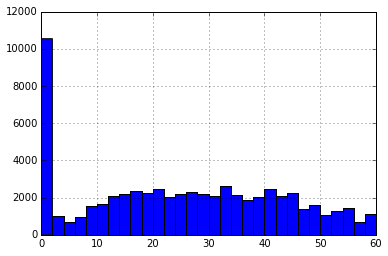

In [151]:
pd.Series(lens).hist(range=(0,60),bins=30)

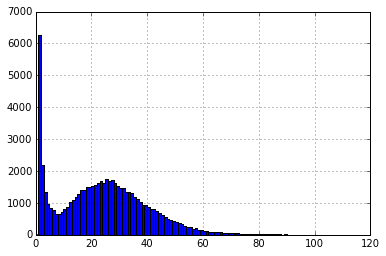

In [152]:
gb.size().hist(range=(0,120),bins=120)